#Installation

In [ ]:
pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 26.6 MB/s eta 0:00:00


In [ ]:
!pip install umap-learn
import umap.umap_ as umap

#Libraries to import

In [ ]:
import os
import zipfile
import pickle
import tarfile
import shutil
from zipfile import ZipFile
import librosa
from IPython.display import Audio
import speechbrain
from speechbrain.inference.speaker import EncoderClassifier
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
import umap.umap_ as umap

import torch
import torchaudio

from torch.nn import Sequential, Linear
from torch.nn import Sigmoid, Tanh, ReLU, LeakyReLU, Bilinear, MSELoss
import torch.nn.functional as F

from torch.optim import Adam

from torch.utils.data import DataLoader

/usr/local/lib/python3.12/dist-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoi

In [ ]:
with zipfile.ZipFile('/content/emotionaudio-librispeech.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/')

#Data Exploring

In [ ]:
def Data_to_Index(file, columns, subsest_position, columns_to_drop=['']):
  df = pd.read_csv(file, delimiter='\t')
  rows = []
  for i in range(len(df)):
    rows.append(df.iloc[i][0].split('|'))
  df = pd.DataFrame(rows, columns=columns)
  my_dataset = []
  for i in range(len(rows)):
      row = [i.strip() for i in df.iloc[i]]
      if row[subsest_position] == 'train-clean-100' or row[subsest_position] == 'dev-clean':
        my_dataset.append(row)
  my_dataset = pd.DataFrame(my_dataset, columns=columns)
  my_dataset.drop(columns=columns_to_drop, inplace=True)
  return my_dataset

In [ ]:
filePATH = '/content/train-clean-100/speakers.TXT'
columns = ['ID_SPEAKER', 'SEX', 'SUBSET', 'MINUTES', 'NAME']
subsest_position = 2
columns_to_drop = ['MINUTES','SUBSET']
speaker_data = Data_to_Index(filePATH, columns, subsest_position, columns_to_drop)

In [ ]:
filePATH = '/content/train-clean-100/chapters.TXT'
columns = ['ID_CHAPTER','ID_SPEAKER','MINUTES', 'SUBSET', 'PROJ', 'ID_BOOK', 'CH TITLE', 'PROJ TITLE']
subsest_position = 3
columns_to_drop = ['MINUTES','SUBSET','PROJ']
chapter_data = Data_to_Index(filePATH, columns, subsest_position, columns_to_drop)

In [ ]:
def to_index(data):
  indexNo_chapter = chapter_data[chapter_data['ID_SPEAKER'] == data].index
  indexNo_speaker = speaker_data[speaker_data['ID_SPEAKER'] == data].index
  return indexNo_chapter[0], indexNo_speaker[0]

>Creación de Dataset_X_vectors

In [ ]:
def Obtain_x_vectors(folder_path):
  y_speaker = []
  path = folder_path
  classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")
  dataset_x_vector = []
  for folder in sorted(os.listdir(path)):
    speakerIndex = to_index(folder)
    for folder2 in os.listdir(path + '/' + folder):
      for folder3 in os.listdir(path + '/' + folder + '/' + folder2):
        if folder3[-5:] == '.flac':
          y_speaker.append(speakerIndex)
          signal, fs = torchaudio.load(path + '/' + folder + '/' + folder2 + '/' + folder3)
          x_vector = classifier.encode_batch(signal).reshape([512])
          dataset_x_vector.append(x_vector)

  return dataset_x_vector, y_speaker


In [ ]:
Valid_Xvectors, y_val = Obtain_x_vectors('/content/dev-clean/dev-clean')
Train_Xvectors, y_train = Obtain_x_vectors('/content/train-clean-100/train-clean-100')

In [ ]:
np.save('/content/drive/MyDrive/LibriSpeech/train_xvector_LS.npy', Train_Xvectors)
np.save('/content/drive/MyDrive/LibriSpeech/valid_xvector_LS.npy', Valid_Xvectors)
np.save('/content/drive/MyDrive/LibriSpeech/y_train_xvector_LS.npy', y_train)
np.save('/content/drive/MyDrive/LibriSpeech/y_valid_xvector_LS.npy', y_val)

In [ ]:
Train_Xvectors = np.load('/content/drive/MyDrive/LibriSpeech/train_xvector_LS.npy')
Valid_Xvectors = np.load('/content/drive/MyDrive/LibriSpeech/valid_xvector_LS.npy')
y_Train = np.load('/content/drive/MyDrive/LibriSpeech/y_train_xvector_LS.npy')
y_Valid = np.load('/content/drive/MyDrive/LibriSpeech/y_valid_xvector_LS.npy')

> Creación de y_persona, y_sexo, y_capítulo

In [ ]:
dicc_sexo = {'M':0,'F':1}
dicc_persona = {c: i for i, c in enumerate(speaker_data['NAME'])}
dicc_nombre_capitulo = {c: i for i, c in enumerate(chapter_data['CH TITLE'])}

In [ ]:
persona = []
sexo = []
nombre_capitulo = []

for y in y_Train:
  persona.append(dicc_persona[speaker_data['NAME'][y[1]]])
  sexo.append(dicc_sexo[speaker_data['SEX'][y[1]]])
  nombre_capitulo.append(dicc_nombre_capitulo[chapter_data['CH TITLE'][y[0]]])

In [ ]:
y_persona = y_Train[:,1]
label_persona = list(dicc_persona.keys())

y_sexo = sexo
label_sexo = list(dicc_sexo.keys())

y_nombre_capitulo = nombre_capitulo
label_nombre_capitulo = list(dicc_nombre_capitulo.keys())

In [ ]:
plotdata = []
pca = PCA(n_components=2)
pca_plot = pca.fit(Train_Xvectors)
plot = pca.transform(Train_Xvectors)

In [ ]:
def plot2d(x,y,labels):
  plt.figure(figsize=(5,5))
  sc = plt.scatter(x[:,0],x[:,1],c=y)
  plt.rcParams['font.family'] = 'sans-serif'
  plt.legend(handles=sc.legend_elements()[0], labels=labels)
  plt.show

In [ ]:
print(Train_Xvectors.shape)
len(label_nombre_capitulo)

In [ ]:
plot2d(Train_Xvectors,y_persona,label_persona)

In [ ]:
plot2d(Train_Xvectors,y_sexo,label_sexo)

In [ ]:
plot2d(Train_Xvectors,y_nombre_capitulo,label_nombre_capitulo)

In [ ]:
x_umap2_StadisticsGlottal_CreamD = umap.UMAP(n_neighbors=100,n_components=2,min_dist=0.1,metric='euclidean').fit_transform(Train_Xvectors,y_sexo)
plot2d(x_umap2_StadisticsGlottal_CreamD,y_sexo,label_sexo)

In [ ]:
x_umap2_StadisticsGlottal_CreamD = umap.UMAP(n_neighbors=100,n_components=2,min_dist=0.1,metric='euclidean').fit_transform(Train_Xvectors,y_nombre_capitulo)
plot2d(x_umap2_StadisticsGlottal_CreamD,y_nombre_capitulo,label_nombre_capitulo)

In [ ]:
x_umap2_StadisticsGlottal_CreamD = umap.UMAP(n_neighbors=100,n_components=2,min_dist=0.1,metric='euclidean').fit_transform(Train_Xvectors,y_persona)
plot2d(x_umap2_StadisticsGlottal_CreamD,y_persona,label_persona)

#Autoencoder

##Data


In [ ]:
embeds_ls_train = np.load('/content/drive/MyDrive/LibriSpeech/train_xvector_LS.npy')
embeds_ls_val = np.load('/content/drive/MyDrive/LibriSpeech/valid_xvector_LS.npy')

##Data Exploration

###Standar Scaler

In [ ]:
scaler_X = StandardScaler()
embeds_ls_train_scale = scaler_X.fit_transform(embeds_ls_train)
embeds_ls_val_scale = scaler_X.transform(embeds_ls_val)

In [ ]:
train_scaler = pd.DataFrame(embeds_ls_train_scale)
val_scaler = pd.DataFrame(embeds_ls_val_scale)

In [ ]:
train_scaler.shape

In [ ]:
train_scaler.describe()

In [ ]:
np.mean(train_scaler.std())

In [ ]:
np.mean(train_scaler.min())

In [ ]:
np.mean(train_scaler.max())

In [ ]:
train_scaler.boxplot(grid=False,figsize=(90,10))

In [ ]:
val_scaler.boxplot(grid=False,figsize=(90,10))

### Robust Scaler

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler_X = RobustScaler()
embeds_ls_train_scale = scaler_X.fit_transform(embeds_ls_train)
embeds_ls_val_scale = scaler_X.transform(embeds_ls_val)

In [ ]:
df_train_scale = pd.DataFrame(embeds_ls_train_scale)
df_valid_scale = pd.DataFrame(embeds_ls_val_scale)

In [ ]:
df_train_scale.boxplot(grid=False,figsize=(90,10))

In [ ]:
df_valid_scale.boxplot(grid=False,figsize=(90,10))

###Normalize

In [ ]:
from sklearn.preprocessing import Normalizer
Normalizer_train = Normalizer().fit_transform(embeds_ls_train)  # fit does nothing.
Normalizer_val = Normalizer().transform(embeds_ls_val)

In [ ]:
Normalizer_train = pd.DataFrame(Normalizer_train)
Normalizer_val = pd.DataFrame(Normalizer_val)

In [ ]:
Normalizer_train.boxplot(grid=False,figsize=(90,10))

In [ ]:
Normalizer_val.boxplot(grid=False,figsize=(90,10))

###Quantile Transformer

In [ ]:
qt = QuantileTransformer(n_quantiles=10, random_state=0)
qt_train = qt.fit_transform(embeds_ls_train)
qt_valid = qt.transform(embeds_ls_val)

In [ ]:
qt_pandas_ent = pd.DataFrame(qt_train)
qt_pandas_val = pd.DataFrame(qt_valid)

In [ ]:
qt_pandas_ent.boxplot(grid=False,figsize=(90,10))

In [ ]:
qt_pandas_val.boxplot(grid=False, figsize=(90,10))

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(15,10))
axes[0].set_title('MEAN')
axes[0].hist([qt_pandas_ent.describe().iloc[1], qt_pandas_val.describe().iloc[1]],
         stacked=False)
axes[0].legend(['df_train', 'df_valid'])

axes[1].set_title('STD')
axes[1].hist([qt_pandas_ent.describe().iloc[2], qt_pandas_val.describe().iloc[2]],
         stacked=False);
axes[1].legend(['df_train_scale', 'df_valid_scale']);

In [ ]:
print('max')
print(np.max(qt_train))
print(np.max(qt_valid))
print('min')
print(np.min(qt_train))
print(np.min(qt_valid))
print('mean')
print(np.mean(np.abs(qt_train)))
print(np.mean(np.abs(qt_valid)))
print('median')
print(np.median(np.abs(qt_train)))
print(np.median(np.abs(qt_valid)))

###Analysing embedings

In [ ]:
def analysisEmbedings(arg1,arg2):
  plt.figure(figsize=(20,5))
  plt.stem(arg1)
  plt.stem(arg2,'black')
  plt.show()

In [ ]:
analysisEmbedings(np.max(qt_train,axis=0),np.max(qt_valid,axis=0))

In [ ]:
analysisEmbedings(np.min(qt_train,axis=0),np.min(qt_valid,axis=0))

In [ ]:
analysisEmbedings(np.mean(qt_train,axis=0),np.mean(qt_valid,axis=0))

In [ ]:
analysisEmbedings(np.median(qt_train,axis=0),np.median(qt_valid,axis=0))

> Tomamos el 10% de los datos de entrenamiento y de validación

##Code

In [ ]:
def plot2d(x,x1):
  plt.figure(figsize=(5,5))
  plt.scatter(x[:,0],x[:,1],c='blue')
  plt.scatter(x1[:,0],x1[:,1],c='red')
  plt.rcParams['font.family'] = 'sans-serif'
  plt.show

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()

##datos

In [ ]:
with open('/content/drive/MyDrive/VESUS/dataset_test1_intended_Actors.pickle','rb') as f:
  dataset_test_1_intended = pickle.load(f)

with open('/content/drive/MyDrive/VESUS/dataset_test1_perceived_Actors.pickle','rb') as f:
  dataset_test_1_perceived = pickle.load(f)

In [ ]:
qt = QuantileTransformer(n_quantiles=10, random_state=0)
qt_train = qt.fit_transform(np.array(dataset_test_1_intended['1']['Angry']['train']))
qt_valid = qt.transform(np.array(dataset_test_1_intended['1']['Angry']['test']))

In [ ]:
qt_train = 2 * (qt_train - 0.5)
qt_valid = 2 * (qt_valid - 0.5)

In [ ]:
qt_valid.shape

In [ ]:
Batch_size = 256

In [ ]:
train_dl = DataLoader(qt_train, batch_size=Batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(qt_valid, batch_size=Batch_size, shuffle=False, num_workers=3, pin_memory=True)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def weights_init_xavier(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

##Model


In [ ]:
class Base(torch.nn.Module):
    def training_step(self, batch):
        out = self(batch)
        loss = F.mse_loss(out, batch)
        return loss, out

    def validation_step(self, batch):
        out = self(batch)
        loss = F.mse_loss(out, batch, reduction='none')
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))
        #print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

In [ ]:
class Modelo(Base):
  def __init__(self):
    super(Modelo, self).__init__()

    self.cod = Sequential(Linear(512, 256),
                          Tanh(),
                          Linear(256, 128),
                          Tanh(),
                          Linear(128, 64),
                          Tanh(),
                          Linear(64, 32),
                          Tanh(),
                          Linear(32, 16))
    self.dec = Sequential(Linear(16, 32),
                          Tanh(),
                          Linear(32, 64),
                          Tanh(),
                          Linear(64, 128),
                          Tanh(),
                          Linear(128, 256),
                          Tanh(),
                          Linear(256, 512))

  def forward(self, x):
    z = self.cod(x)
    x = self.dec(z)

    return x

In [ ]:
model_ac = to_device(Modelo(), device)
#model_ac.apply(weights_init_xavier)

##Trainning

In [ ]:
def evaluate(model_ac, val_loader):
    model_ac.eval()
    outputs = [model_ac.validation_step(batch) for batch in val_loader]
    return model_ac.validation_epoch_end(outputs)

def evaluation(model_ac, val_loader):
    model_ac.eval()
    outputs = [model_ac.validation_step(batch) for batch in val_loader]
    return [x.mean() for x in outputs[0]['val_loss']]

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def try_model(epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    #torch.cuda.empty_cache()
    history = []
    early_stop = [0,0,0,0,0]

    optimizer = opt_func(model.parameters(), lr, weight_decay = weight_decay)
    prev_val_loss = 1
    saved = 1
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()

        train_losses = []
        input_vector = []
        output_vector = []
        lrs = []

        for batch in train_loader:
            optimizer.zero_grad()

            loss, out = model.training_step(batch)
            train_losses.append(loss)

            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()

        early_stop.insert(epoch % 5, round(result['val_loss'], 4))
        early_stop.pop(epoch % 5 + 1)
        if epoch == 0:
          model.epoch_end(epoch, result)
        history.append(result)
        if np.mean(early_stop) == round(result['val_loss'],4):
          break
    return history

In [ ]:
epochs = 100
max_lr = 1e-3
grad_clip = 1e-4
weight_decay = 1e-4
opt_func = torch.optim.Adam

##train

In [ ]:
history = [evaluate(model_ac, train_dl)]
history

In [ ]:
history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl, weight_decay, grad_clip, opt_func=opt_func)

We first pre-train the autoencoders using neutral speech from the LibriSpeech corpus

In [ ]:
#we save the weights
#torch.save(model_ac.state_dict(), '/content/drive/MyDrive/LibriSpeech/librispeech_pre_training.pth')

In [ ]:
def plot_loss(history):
    validation = [x['val_loss'] for x in history[1:]]
    train = [x['train_loss'] for x in history[1:]]
    plt.plot(validation, '-x')
    plt.plot(train, '-o')
    plt.xlabel('epoch')
    plt.ylabel('train loss orange, valid loss blue')
    plt.title('validation vs. No. of epochs');

In [ ]:
plot_loss(history)

In [ ]:
def plot_accuracies(history):
    validation = [x['val_loss'] for x in history[1:]]
    train = [x['train_loss'] for x in history[1:]]
    plt.plot(validation, '-x')
    plt.plot(train, '-o')
    plt.xlabel('epoch')
    plt.ylabel('train loss orange, valid loss blue')
    plt.title('validation vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_valid(history):
    validation = [x['val_loss'] for x in history]
    plt.plot(validation, '-x')
    plt.xlabel('epoch')
    plt.ylabel('val_loss')
    plt.title('validation vs. No. of epochs');

In [ ]:
plot_valid(history)

Now that the model is trained with the Librispeech dataset, (which is a set of neutral voices from different actors), we use the VESUS dataset (which is a set of emotional speech) to analyze the reconstruction error and decide if it has emotional content

#Pre-Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
weights = torch.load('/content/drive/MyDrive/LibriSpeech/librispeech_pre_training.pth', map_location=torch.device('cpu'))

<ipython-input-5-2b8c205a9b80>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('/content/drive/MyDrive/LibriSpeech/librispeech_pre_training.pth', map_l

#VESUS - Speech Emotional Content

##Data

In [ ]:
!kaggle datasets download -d marianarodrguez/emotionaudio-librispeech

Dataset URL: https://www.kaggle.com/datasets/marianarodrguez/emotionaudio-librispeech
License(s): unknown
100% 10.3G/10.3G [01:56<00:00, 132MB/s]
100% 10.3G/10.3G [01:56<00:00, 95.4MB/s]


In [ ]:
with zipfile.ZipFile('/content/emotionaudio-librispeech.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/')

##Xvectors

We run two separate analyses
whenever we use the VESUS dataset: one using the intended
(i.e., instructed) emotion labels, and another using utterances
that achieved at least 50% consistency among the crowd-
sourced annotators (i.e., at least five annotators agreed).

In [ ]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")
signal, _ = torchaudio.load('/content/drive/MyDrive/MuSe/Instru/1002174.mp3')
signal = signal[:48000]
x_vector = classifier.encode_batch(signal)
x_vector.shape

torch.Size([2, 1, 512])

In [ ]:
def Xvectors(path):
  classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")
  folder_audio = '/content/VESUS/VESUS' + path
  signal, _ = torchaudio.load(folder_audio)
  x_vector = classifier.encode_batch(signal).reshape([512])
  return x_vector.numpy()

In [ ]:
csv_file_path = '/content/drive/MyDrive/VESUS/VESUS_Key.csv'
df = pd.read_csv(csv_file_path)

In [ ]:
emotion_dict = {'Neutral':0,'Angry':1,'Happy':2,'Sad':3,'Fearful':4}

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
dict_percived = {str(i): {emotion: [] for emotion in emotions} for i in range(1, 11)}

emotion_dict = {'Neutral':'0','Angry':'1','Happy':'2','Sad':'3','Fearful':'4'}

for row in range(len(df)):
  actor = df.iloc[row]['Actor Number']
  emotion = df.iloc[row]['Instructed Emotion']
  if emotion in ['Neutral', 'Happy', 'Sad', 'Angry']:
    perceived = df.iloc[row]['Perceived Emotion 0:Neu,Ang,Hap,Sad,4:Fea']
    rate = perceived.count(emotion_dict[emotion])
    if rate >= 5:
      dict_percived[str(actor)][emotion].append(df.iloc[row]['File Path'])

In [ ]:
emotions = ['Neutral', 'Angry', 'Sad', 'Happy']
dataset_types = ['train', 'test']

dataset_test_1_intended = {str(i): {emotion: {dtype: [] for dtype in dataset_types}for emotion in emotions} for i in range(1, 11)}
dataset_test_1_perceived = {str(i): {emotion: {dtype: [] for dtype in dataset_types}for emotion in emotions} for i in range(1, 11)}

In [ ]:
def ends(actor, emotion):
  path = '/content/VESUS/VESUS/' + str(actor) + '/' + emotion
  lenght = len(os.listdir(path))
  end = int(lenght * 0.7)
  end_p = int(len(dict_percived[str(actor)][emotion])*0.7)
  return end, end_p

In [ ]:
emotions = ['Neutral', 'Angry', 'Sad', 'Happy']
emotion_dict = {'Neutral':'0','Angry':'1','Happy':'2','Sad':'3','Fearful':'4'}

for row in range(len(df)):
  emotion = df.iloc[row]['Instructed Emotion']
  if emotion in emotions:
    actor_n = df.iloc[row]['Actor Number']
    perceived = df.iloc[row]['Perceived Emotion 0:Neu,Ang,Hap,Sad,4:Fea']
    path = df.iloc[row]['File Path']

    end_train, end_train_p = ends(actor_n, emotion)
    part = "train"
    lenght = len(dataset_test_1_intended[str(actor_n)][emotion][part])
    if lenght == end_train:
      part = 'test'
    x = Xvectors(path)
    dataset_test_1_intended[str(actor_n)][emotion][part].append(x)

    rate = perceived.count(emotion_dict[emotion])
    if rate >= 5:
      part = "train"
      lenght = len(dataset_test_1_perceived[str(actor_n)][emotion][part])
      if lenght == end_train_p:
        part = 'test'
      dataset_test_1_perceived[str(actor_n)][emotion][part].append(x)

In [ ]:
with open('/content/drive/MyDrive/VESUS/dataset_test1_perceived_Actors_CORRECTED.pickle', 'wb') as f:
    pickle.dump(dataset_test_1_perceived, f)

with open('/content/drive/MyDrive/VESUS/dataset_test1_intended_Actors_CORRECTED.pickle', 'wb') as f:
    pickle.dump(dataset_test_1_intended, f)

##Reconstruction Error

In [ ]:
dataset_test1_intended_history = {'1':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '2':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '3':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '4':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '5':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '6':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '7':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '8':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '9':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                 '10':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []}}

In [ ]:
dataset_test1_perceived_history = {'1':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '2':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '3':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '4':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '5':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '6':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '7':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '8':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '9':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '10':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []}}

In [ ]:
with open('/content/drive/MyDrive/VESUS/dataset_test1_intended_Actors_CORRECTED.pickle', 'rb') as f:
  test1_Intended = pickle.load(f)
with open('/content/drive/MyDrive/VESUS/dataset_test1_perceived_Actors_CORRECTED.pickle', 'rb') as f:
  test1_Perceived = pickle.load(f)

In [ ]:
print(len(test1_Perceived['1']['Neutral']['train']))
len(test1_Perceived['6']['Sad']['test'])

170


39

In [ ]:
print(len(test1_Intended['1']['Angry']['train']))
len(test1_Intended['1']['Angry']['test'])

176


76

In [ ]:
def normalization(dataset, actor_n, emotion):
    qt = QuantileTransformer(n_quantiles=10, random_state=0)
    lenght = len(dataset[actor_n][emotion]['test'])
    if  lenght == 75:
      dataset[actor_n][emotion]['test'].append(dataset[actor_n][emotion]['train'][0])
    qt_train = qt.fit_transform(np.array(dataset[actor_n][emotion]['train']))
    qt_valid = qt.transform(np.array(dataset[actor_n][emotion]['test']))
    qt_train = 2 * (qt_train - 0.5)
    qt_valid = 2 * (qt_valid - 0.5)
    return qt_train, qt_valid

def dataloader_Norm(qt_train, qt_valid):
    Batch_size = 256
    train_dl = DataLoader(qt_train, batch_size=Batch_size, shuffle=True, num_workers=2, pin_memory=True)
    valid_dl = DataLoader(qt_valid, batch_size=Batch_size, shuffle=False, num_workers=2, pin_memory=True)
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)
    return train_dl, valid_dl

In [ ]:
emotions = ['Happy','Sad', 'Angry']

for actor_n in range(1,11):
  model_ac.load_state_dict(weights)
  qt_train, qt_valid = normalization(test1_Intended,str(actor_n),'Neutral')
  train_dl, valid_dl = dataloader_Norm(qt_train, qt_valid)
  history = [evaluate(model_ac, train_dl)]
  history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl, weight_decay, grad_clip, opt_func=opt_func)
  eval = evaluation(model_ac, valid_dl)
  dataset_test1_intended_history[str(actor_n)]['Neutral'].append(eval)

  for emotion in emotions:
    qt_train, qt_valid = normalization(test1_Intended,str(actor_n),emotion)
    train_dl, valid_dl = dataloader_Norm(qt_train, qt_valid)
    eval = evaluation(model_ac, valid_dl)
    dataset_test1_intended_history[str(actor_n)][emotion].append(eval)


In [ ]:
emotions = ['Happy', 'Sad', 'Angry']

for actor_n in range(1,11):
  model_ac.load_state_dict(weights)
  qt_train, qt_valid = normalization(test1_Perceived,str(actor_n),'Neutral')
  train_dl, valid_dl = dataloader_Norm(qt_train, qt_valid)
  history = [evaluate(model_ac, train_dl)]
  history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl, weight_decay, grad_clip, opt_func=opt_func)
  eval = evaluation(model_ac, valid_dl)
  dataset_test1_perceived_history[str(actor_n)]['Neutral'].append(eval)

  for emotion in emotions:
    qt_train, qt_valid = normalization(test1_Perceived,str(actor_n),emotion)
    train_dl, valid_dl = dataloader_Norm(qt_train, qt_valid)
    eval = evaluation(model_ac, valid_dl)
    dataset_test1_perceived_history[str(actor_n)][emotion].append(eval)


Epoch [0], train_loss: 0.2249, val_loss: 0.2236
Epoch [0], train_loss: 0.2315, val_loss: 0.2363
Epoch [0], train_loss: 0.2307, val_loss: 0.2231
Epoch [0], train_loss: 0.2374, val_loss: 0.2423
Epoch [0], train_loss: 0.2469, val_loss: 0.2454
Epoch [0], train_loss: 0.2230, val_loss: 0.2287
Epoch [0], train_loss: 0.2156, val_loss: 0.2110
Epoch [0], train_loss: 0.2439, val_loss: 0.2470
Epoch [0], train_loss: 0.2282, val_loss: 0.2345


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (10) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(


Epoch [0], train_loss: 0.2391, val_loss: 0.2426


In [ ]:
with open('/content/drive/MyDrive/VESUS/dataset_test1_intended_historyCORRECTED.pickle', 'wb') as f:
  pickle.dump(dataset_test1_intended_history,f)

In [ ]:
with open('/content/drive/MyDrive/VESUS/dataset_test1_perceived_historyCORRECTED.pickle', 'wb') as f:
  pickle.dump(dataset_test1_perceived_history, f)

##Graficar

In [ ]:
perceived_history = dataset_test1_perceived_history

In [ ]:
with open('/content/drive/MyDrive/VESUS/dataset_test1_intended_historyCORRECTED.pickle', 'rb') as f:
  intended_history = pickle.load(f)
with open('/content/drive/MyDrive/VESUS/dataset_test1_perceived_historyCORRECTED.pickle', 'rb') as f:
  perceived_history = pickle.load(f)

In [ ]:
def datasetEmotions(history, genre):
  dictForM = {'Female': [1,6],'Male': [6,11]}
  rangeForM = dictForM[genre]
  emotions = ['Neutral', 'Angry', 'Happy', 'Sad']

  data_per_emotion = []
  data_per_actor = []

  for emotion in emotions:
    for actor_n in range(rangeForM[0],rangeForM[1]):
      for RE in history[str(actor_n)][emotion][0]:
        data_per_actor.append(RE)
    data_per_emotion.append(data_per_actor)
    data_per_actor = []
  return data_per_emotion

In [ ]:
def dataframe(data_per_emotion):
  return pd.DataFrame(np.array(data_per_emotion).T)

def dataframe_P(data_per_emotion):
  data_per_emotion1 = pd.DataFrame(np.array(data_per_emotion[0]).T)
  data_per_emotion2 = pd.DataFrame(np.array(data_per_emotion[1]).T)
  data_per_emotion3 = pd.DataFrame(np.array(data_per_emotion[2]).T)
  data_per_emotion4 = pd.DataFrame(np.array(data_per_emotion[3]).T)
  return pd.concat([data_per_emotion1, data_per_emotion2, data_per_emotion3, data_per_emotion4], axis=1)

In [ ]:
intended_Female = datasetEmotions(intended_history, 'Female')
intended_Male = datasetEmotions(intended_history, 'Male')
perceived_Female = datasetEmotions(perceived_history, 'Female')
perceived_Male = datasetEmotions(perceived_history, 'Male')

In [ ]:
intended_Female = dataframe(intended_Female)
intended_Male = dataframe(intended_Male)
perceived_Female = dataframe_P(perceived_Female)
perceived_Male = dataframe_P(perceived_Male)

In [ ]:
perceived_Female.columns = ['Neutral', 'Angry', 'Happy', 'Sad']
perceived_Male.columns = ['Neutral', 'Angry', 'Happy', 'Sad']

In [ ]:
columns = ['Neutral', 'Angry', 'Happy', 'Sad']

In [ ]:
def plot_box(plotbox, genre, columns, fig):
    plotbox.columns = columns
    bp = plotbox.boxplot(grid=True, figsize=(18, 9), fontsize=37)
    #plotbox.boxplot(grid=True, figsize=(18, 9), fontsize=37)
    plt.gca().grid(True, linewidth=3)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Ajusta el grosor del marco
    for element in ['boxes', 'whiskers', 'caps', 'medians']:
      print(bp)
      for line in bp[0]:
        print(line)
        line.set_linewidth(2)  # Ajusta el grosor aquí
    plt.ylabel('Reconstruction Error', fontsize=37)
    plt.title(genre, fontsize=37)
    plt.yticks(np.arange(0.05, 0.41, 0.1))
    plt.savefig(f'{fig}.png', format='png', bbox_inches='tight')#eps
    plt.show()

In [ ]:
plotbox.boxplot(grid=True, figsize=(18, 9), fontsize=37)
  plt.ylabel('Reconstruction Error', fontsize=37)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_box(plotboxes, genre, figu):

    if not isinstance(plotboxes, pd.DataFrame):
        raise ValueError("The input plotboxes must be a pandas DataFrame.")
    if plotboxes.shape[1] < 4:
        raise ValueError("The DataFrame must have at least 4 columns.")


    fig, ax = plt.subplots(figsize=(18, 9))


    bp = ax.boxplot(
        [plotboxes[col].dropna().values for col in plotboxes.columns],  # Drop NaN values
        patch_artist=True,
        widths=0.6
    )

    for spine in ax.spines.values():
        spine.set_linewidth(2)

    ax.grid(True, linewidth=2)

    for element in ['boxes', 'whiskers', 'caps', 'medians']:
        for line in bp[element]:
            line.set_linewidth(2)

    ax.set_xticks(np.arange(1, len(plotboxes.columns) + 1))
    ax.set_xticklabels(plotboxes.columns, fontsize=37)

    # Set labels and title
    plt.ylabel('Reconstruction Error', fontsize=37)
    plt.title(genre, fontsize=37)
    plt.yticks(np.arange(0.05, 0.41, 0.1), fontsize=37)

    plt.savefig(f'{figu}.png', format='png', bbox_inches='tight')

    plt.show()


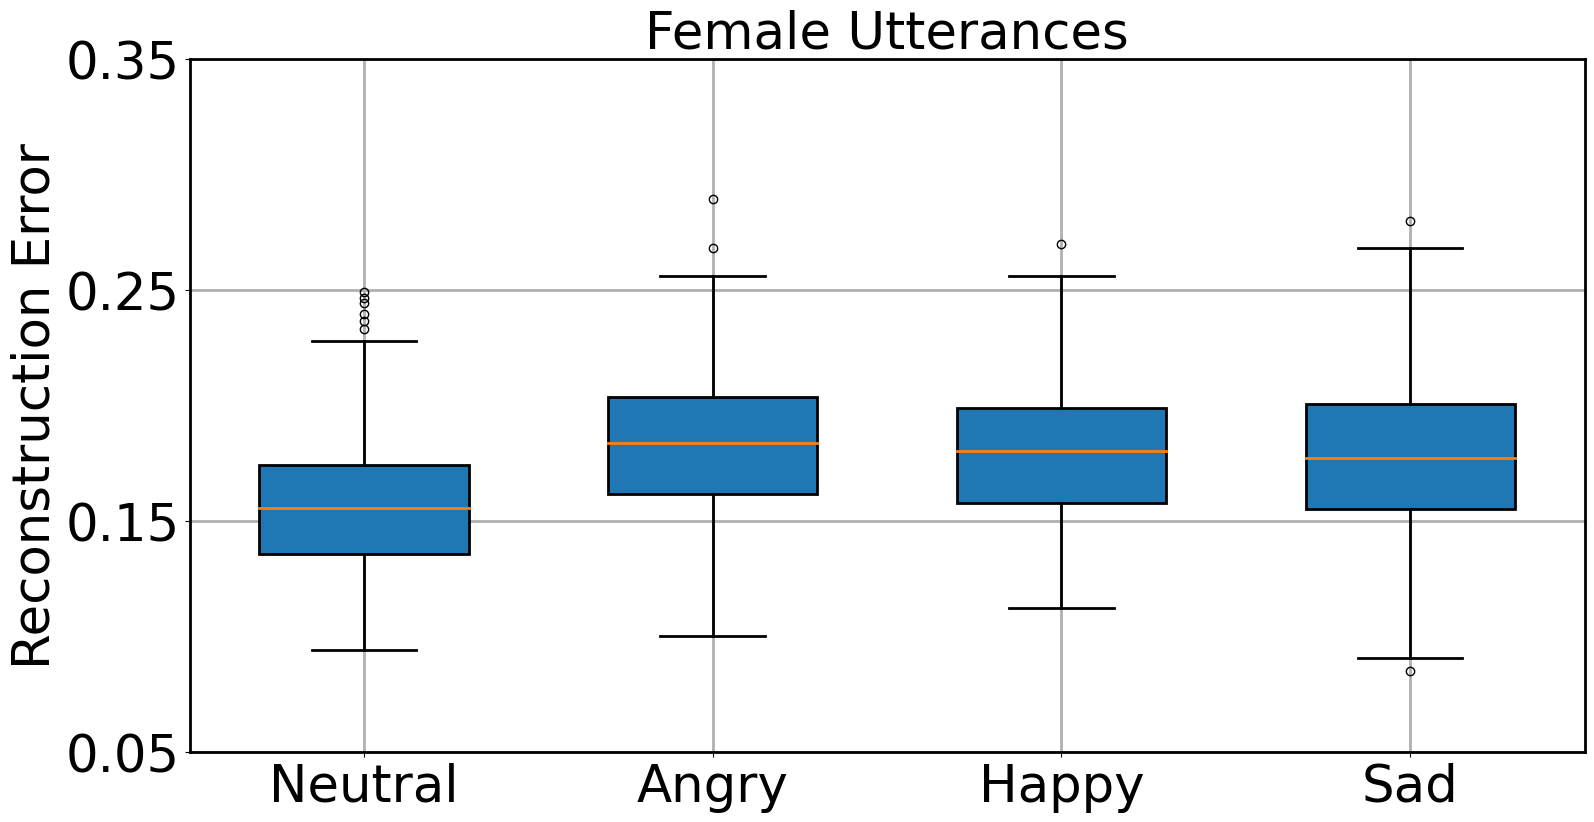

In [ ]:
plot_box(perceived_Female, 'Female Utterances','FemalePerceived')

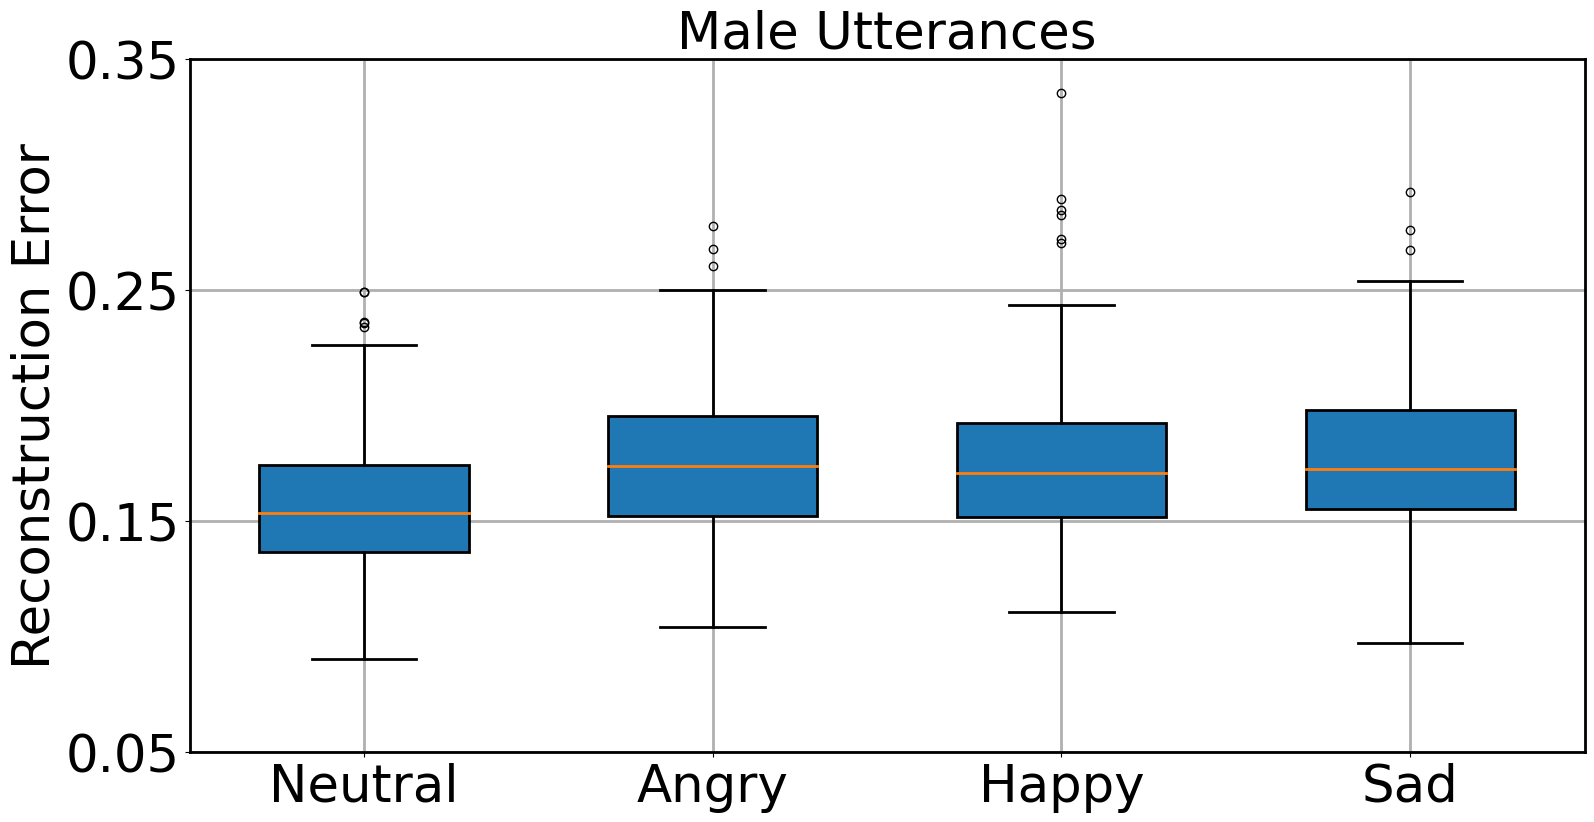

In [ ]:
plot_box(perceived_Male, 'Male Utterances', 'Malepercived')

#Music - Instrument Emotional Content

##Dataset

In [ ]:
df_Instrument = pd.read_csv('/content/autotagging_instrument.csv', delimiter='\t')

<ipython-input-207-eba1dee93a65>:1: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Instrument = pd.read_csv('/content/autotagging_instrument.csv', delimiter='\t')


In [ ]:
df_Instrument.replace('NaN', np.nan, inplace=True)

In [ ]:
filtered_df = df_Instrument[df_Instrument.iloc[:, 6:].isna().all(axis=1)]

In [ ]:
filtered_df

,TRACK_ID,ARTIST_ID,ALBUM_ID,PATH,DURATION,TAGS,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35
0,track_0000382,artist_000020,album_000046,82/382.mp3,211.1,instrument---voice,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,track_0000383,artist_000020,album_000046,83/383.mp3,113.1,instrument---voice,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,track_0000384,artist_000020,album_000046,84/384.mp3,115.7,instrument---voice,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,track_0000386,artist_000020,album_000046,86/386.mp3,103.4,instrument---voice,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,track_0000387,artist_000020,album_000046,87/387.mp3,257.1,instrument---voice,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25130,track_1422056,artist_496314,album_165847,56/1422056.mp3,516.0,instrument---computer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25131,track_1422057,artist_496314,album_165847,57/1422057.mp3,374.9,instrument---computer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25132,track_1422058,artist_496314,album_165847,58/1422058.mp3,315.8,instrument---computer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25133,track_1422059,artist_496314,album_165847,59/1422059.mp3,201.3,instrument---computer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i in range(len(df_Instrument)):
  if str(filtered_df.iloc[i]['TAGS'])[13:] == 'violin':
    filtered_df.loc[i, 'more'] = 'instrument---violin'

In [ ]:
guitar = ['acousticguitar', 'electricguitar', 'classicalguitar', 'acousticbassguitar', '']

In [ ]:
for i in range(len(df_Instrument)):
  for j in range(len(guitar)):
    if str(filtered_df.iloc[i]['TAGS'])[13:] == guitar[j]:
      filtered_df.loc[i, 'more'] = 'instrument---guitar'

In [ ]:
for i in range(len(df_Instrument)):
  if str(df_Instrument.iloc[i]['TAGS'])[13:] == 'bass':
    filtered_df.loc[i, 'more'] = 'instrument---bass'

In [ ]:
for i in range(len(df_Instrument)):
    if str(df_Instrument.iloc[i]['TAGS'])[13:] == 'piano':
      df_Instrument.loc[i, 'TAGS'] = 'instrument---piano'
    if str(df_Instrument.iloc[i]['TAGS'])[13:] == 'keyboard':
      filtered_df.loc[i, 'more'] = 'instrument---piano'

In [ ]:
df_Mood = pd.read_csv('/content/autotagging_moodtheme.tsv', delimiter='\t')

In [ ]:
df_Mood.loc['more_tags'] = 'unknow'

In [ ]:
sad = ['meditative','slow', 'sad','emotional', 'melancholic', 'deep', 'dream']

In [ ]:
for i in range(len(df_Mood)):
  for j in range(len(sad)):
    if str(df_Mood.iloc[i]['TAGS'])[13:] == sad[j] or str(df_Mood.iloc[i]['Unnamed: 6'])[13:] == sad[j] or str(df_Mood.iloc[i]['Unnamed: 7'])[13:] == sad[j] or str(df_Mood.iloc[i]['Unnamed: 8'])[13:] == sad[j] or str(df_Mood.iloc[i]['Unnamed: 9'])[13:] == sad[j] or str(df_Mood.iloc[i]['Unnamed: 10'])[13:] == sad[j] or str(df_Mood.iloc[i]['Unnamed: 11'])[13:] == sad[j] or str(df_Mood.iloc[i]['Unnamed: 12'])[13:] == sad[j]:
      df_Mood.loc[i, 'more_tags'] = 'sad'

In [ ]:
angry = ['energetic','dark','heavy', 'horror','powerful' , 'action']#, 'fast']

In [ ]:
for i in range(len(df_Mood)):
  for j in range(len(angry)):
    if str(df_Mood.iloc[i]['TAGS'])[13:] == angry[j] or str(df_Mood.iloc[i]['Unnamed: 6'])[13:] == angry[j] or str(df_Mood.iloc[i]['Unnamed: 7'])[13:] == angry[j] or str(df_Mood.iloc[i]['Unnamed: 8'])[13:] == angry[j] or str(df_Mood.iloc[i]['Unnamed: 9'])[13:] == angry[j] or str(df_Mood.iloc[i]['Unnamed: 10'])[13:] == angry[j] or str(df_Mood.iloc[i]['Unnamed: 11'])[13:] == angry[j] or str(df_Mood.iloc[i]['Unnamed: 12'])[13:] == angry[j]:
      df_Mood.loc[i, 'more_tags'] = 'dark'

In [ ]:
happy = ['fun', 'funny', 'happy','uplifting','upbeat', 'positive', 'motivational', 'children','christmas']

In [ ]:
for i in range(len(df_Mood)):
  for j in range(len(happy)):
    if str(df_Mood.iloc[i]['TAGS'])[13:] == happy[j] or str(df_Mood.iloc[i]['Unnamed: 6'])[13:] == happy[j] or str(df_Mood.iloc[i]['Unnamed: 7'])[13:] == happy[j] or str(df_Mood.iloc[i]['Unnamed: 8'])[13:] == happy[j] or str(df_Mood.iloc[i]['Unnamed: 9'])[13:] == happy[j] or str(df_Mood.iloc[i]['Unnamed: 10'])[13:] == happy[j] or str(df_Mood.iloc[i]['Unnamed: 11'])[13:] == happy[j] or str(df_Mood.iloc[i]['Unnamed: 12'])[13:] == happy[j]:
      df_Mood.loc[i, 'more_tags'] = 'happy'


In [ ]:
df_moodInstrument = pd.merge(filtered_df, df_Mood, on='TRACK_ID', how='inner')

In [ ]:
df_moodInstrument

,TRACK_ID,ARTIST_ID_x,ALBUM_ID_x,PATH_x,DURATION_x,TAGS_x,Unnamed: 6_x,Unnamed: 7_x,Unnamed: 8_x,Unnamed: 9_x,...,DURATION_y,TAGS_y,Unnamed: 6_y,Unnamed: 7_y,Unnamed: 8_y,Unnamed: 9_y,Unnamed: 10_y,Unnamed: 11_y,Unnamed: 12_y,more_tags
0,track_0000948,artist_000087,album_000149,48/948.mp3,212.7,instrument---synthesizer,NaN,NaN,NaN,NaN,...,212.7,mood/theme---background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,track_0000950,artist_000087,album_000149,50/950.mp3,248.0,instrument---synthesizer,NaN,NaN,NaN,NaN,...,248.0,mood/theme---background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,track_0000951,artist_000087,album_000149,51/951.mp3,199.7,instrument---synthesizer,NaN,NaN,NaN,NaN,...,199.7,mood/theme---background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,track_0006248,artist_000811,album_000960,48/6248.mp3,249.8,instrument---piano,NaN,NaN,NaN,NaN,...,249.8,mood/theme---documentary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,track_0006606,artist_000787,album_001009,06/6606.mp3,224.9,instrument---accordion,NaN,NaN,NaN,NaN,...,224.9,mood/theme---melodic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,track_1422056,artist_496314,album_165847,56/1422056.mp3,516.0,instrument---computer,NaN,NaN,NaN,NaN,...,516.0,mood/theme---advertising,mood/theme---dramatic,mood/theme---epic,mood/theme---movie,NaN,NaN,NaN,NaN,NaN
4763,track_1422057,artist_496314,album_165847,57/1422057.mp3,374.9,instrument---computer,NaN,NaN,NaN,NaN,...,374.9,mood/theme---advertising,mood/theme---dramatic,mood/theme---epic,mood/theme---movie,NaN,NaN,NaN,NaN,NaN
4764,track_1422058,artist_496314,album_165847,58/1422058.mp3,315.8,instrument---computer,NaN,NaN,NaN,NaN,...,315.8,mood/theme---dramatic,mood/theme---epic,mood/theme---movie,NaN,NaN,NaN,NaN,NaN,NaN
4765,track_1422059,artist_496314,album_165847,59/1422059.mp3,201.3,instrument---computer,NaN,NaN,NaN,NaN,...,201.3,mood/theme---advertising,mood/theme---dramatic,mood/theme---epic,mood/theme---movie,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df_moodInstrument[['TRACK_ID', 'TAGS_x', 'more_tags']]

In [ ]:
df

,TRACK_ID,TAGS_x,more_tags
0,track_0000948,instrument---synthesizer,NaN
1,track_0000950,instrument---synthesizer,NaN
2,track_0000951,instrument---synthesizer,NaN
3,track_0006248,instrument---piano,NaN
4,track_0006606,instrument---accordion,NaN
...,...,...,...
4762,track_1422056,instrument---computer,NaN
4763,track_1422057,instrument---computer,NaN
4764,track_1422058,instrument---computer,NaN
4765,track_1422059,instrument---computer,NaN


In [ ]:
emotions = ['happy', 'sad', 'angry']
instruments = ['piano', 'violin', 'guitar', 'bass']
divisions =['train', 'test']

In [ ]:
instruments = ["piano", "violin", "guitar", "bass"]
splits = ["train", "test"]
moods = ["happy", "sad", "angry"]

dataset = {
    inst: {
        split: {mood: [] for mood in moods}
        for split in splits
    }
    for inst in instruments
}


In [ ]:
moods = ["happy", "sad", "angry", "bass"]

dataset_Mood = {
    mood: {"train": [], "test": []}
    for mood in moods
}

In [ ]:
instruments = ["piano", "violin", "guitar", "bass"]

dataset_Instrument = {
    inst: {"train": [], "test": []}
    for inst in instruments
}


In [ ]:
for i in range(len(df)):
  emotion_i = str(df.iloc[i]['more_tags'])
  instrument_i = str(df.iloc[i]['TAGS_x'][13:])

  if (emotion_i in emotions) and (instrument_i in instruments):
    dataset[instrument_i]['train'][emotion_i].append(df.iloc[i]['TRACK_ID'])

In [ ]:
for i in instruments:
  for d in divisions:
    for e in emotions:
      dataset_Instrument[i][d].append(dataset[i][d][e])

In [ ]:
for e in emotions:
  for d in divisions:
    for i in instruments:
      dataset_Mood[e][d].append(dataset[i][d][e])

In [ ]:
for i in instruments:
    dataset_Instrument[i]['train'] = np.array(dataset_Instrument[i]['train']).reshape([210])
    dataset_Instrument[i]['test'] = np.array(dataset_Instrument[i]['test']).reshape([60])
    print('train')
    print(i)
    print(len(dataset_Instrument[i]['train']))
    print('test')
    print(i)
    print(len(dataset_Instrument[i]['test']))

train
piano
210
test
piano
60
train
violin
210
test
violin
60
train
guitar
210
test
guitar
60
train
bass
210
test
bass
60


In [ ]:
for e in emotions:
    dataset_Mood[e]['train'] = np.array(dataset_Mood[e]['train']).reshape([280])
    dataset_Mood[e]['test'] = np.array(dataset_Mood[e]['test']).reshape([80])
    print('train')
    print(e)
    print(len(dataset_Mood[e]['train']))
    print('test')
    print(e)
    print(len(dataset_Mood[e]['test']))

train
happy
280
test
happy
80
train
sad
280
test
sad
80
train
dark
280
test
dark
80


We obtain x-vectors embeddings

##xvector

In [ ]:
emotions = ["Relax", "Angry", "Sad", "Happy"]
dataset_Music = {f"{emo}_all": {"train": [], "test": []} for emo in emotions}

In [ ]:
def Xvectors_m(path):
  max_samples = 44100
  y, sr = librosa.load(path)
  if len(y) > max_samples:
    y = y[:max_samples]
  elif len(y) < max_samples:
    y = np.pad( y, pad_width = (0, max_samples - len(y)), mode='constant')
  classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")
  signal = torch.tensor(y)
  x_vector = classifier.encode_batch(signal).reshape([512])
  return x_vector.numpy()

In [ ]:
folders = ["Relax_all", "Angry_all", "Sad_all", "Happy_all"]
base_path = "/content/emotion-recognition-236f22a6fde0/4. dataset (audio)/"

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    end_train = end_m(folder_path)

    for i, audio_name in enumerate(sorted(os.listdir(folder_path))):
        part = "train" if i < end_train else "test"
        audio_path = os.path.join(folder_path, audio_name)

        x = Xvectors_m(audio_path)
        dataset_Music[folder][part].append(x)


In [ ]:
with open('/content/drive/MyDrive/VESUS/dataset_Music.pickle', 'wb') as f:
    pickle.dump(dataset_Music, f)

In [ ]:
with open('/content/drive/MyDrive/VESUS/dataset_Music.pickle', 'rb') as f:
    dataset_Music = pickle.load( f)

##Reconstruction error

In [ ]:
def normalization(dataset, emotion):
    qt = QuantileTransformer(n_quantiles=10, random_state=0)
    qt_train = qt.fit_transform(np.array(dataset[emotion]['train']))
    qt_valid = qt.transform(np.array(dataset[emotion]['test']))
    qt_train = 2 * (qt_train - 0.5)
    qt_valid = 2 * (qt_valid - 0.5)
    return qt_train, qt_valid

def dataloader_Norm(qt_train, qt_valid):
    Batch_size = 256
    train_dl = DataLoader(qt_train, batch_size=len(qt_train), shuffle=True, num_workers=2, pin_memory=True)
    valid_dl = DataLoader(qt_valid, batch_size=len(qt_valid), shuffle=False, num_workers=2, pin_memory=True)
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)
    return train_dl, valid_dl

In [ ]:
dataset_Music_history = {'Relax_all': [], 'Angry_all': [], 'Sad_all': [], 'Happy_all': []}

In [ ]:
emotions = ['Happy_all','Sad_all', 'Angry_all']


model_ac.load_state_dict(weights)
qt_train, qt_valid = normalization(dataset_Music,'Relax_all')
train_dl, valid_dl = dataloader_Norm(qt_train, qt_valid)
history = [evaluate(model_ac, train_dl)]
history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl, weight_decay, grad_clip, opt_func=opt_func)

valid = np.vstack([qt_train, qt_valid])
valid = DataLoader(valid, batch_size=len(valid), shuffle=False, num_workers=2, pin_memory=True)
valid = DeviceDataLoader(valid, device)
eval = evaluation(model_ac, valid)
dataset_Music_history['Relax_all'].append(eval)

for emotion in emotions:
  qt_train, qt_valid = normalization(dataset_Music, emotion)
  valid = np.vstack([qt_train, qt_valid])
  valid = DataLoader(valid, batch_size=len(valid), shuffle=False, num_workers=2, pin_memory=True)
  valid = DeviceDataLoader(valid, device)
  eval = evaluation(model_ac, valid)
  dataset_Music_history[emotion].append(eval)


Epoch [0], train_loss: 0.2366, val_loss: 0.2415


In [ ]:
with open('/content/drive/MyDrive/VESUS/dataset_Music_history.pickle', 'wb') as file:
        pickle.dump(dataset_Music_history, file)

##graficar

In [ ]:
def dataframe_M(data_per_emotion):
  data_per_emotion1 = pd.DataFrame(np.array(data_per_emotion['Relax_all']).T)
  data_per_emotion2 = pd.DataFrame(np.array(data_per_emotion['Happy_all']).T)
  data_per_emotion3 = pd.DataFrame(np.array(data_per_emotion['Sad_all']).T)
  data_per_emotion4 = pd.DataFrame(np.array(data_per_emotion['Angry_all']).T)
  return pd.concat([data_per_emotion1, data_per_emotion2, data_per_emotion3, data_per_emotion4], axis=1)

In [ ]:
Music = dataframe_M(dataset_Music_history)

In [ ]:
def plot_box(plotbox, columns, fig):
  plotbox.columns = columns
  plotbox.boxplot(grid=True, figsize=(18, 9), fontsize=37)
  plt.ylabel('Reconstruction Error', fontsize=37)
  #plt.title('Genre', fontsize=15)
  plt.yticks(np.arange(0, 0.5, 0.1))
  plt.savefig(f'{fig}.png', format='png', bbox_inches='tight')
  plt.show()

In [ ]:
columns = ['relax', 'happy', 'sad', 'angry']

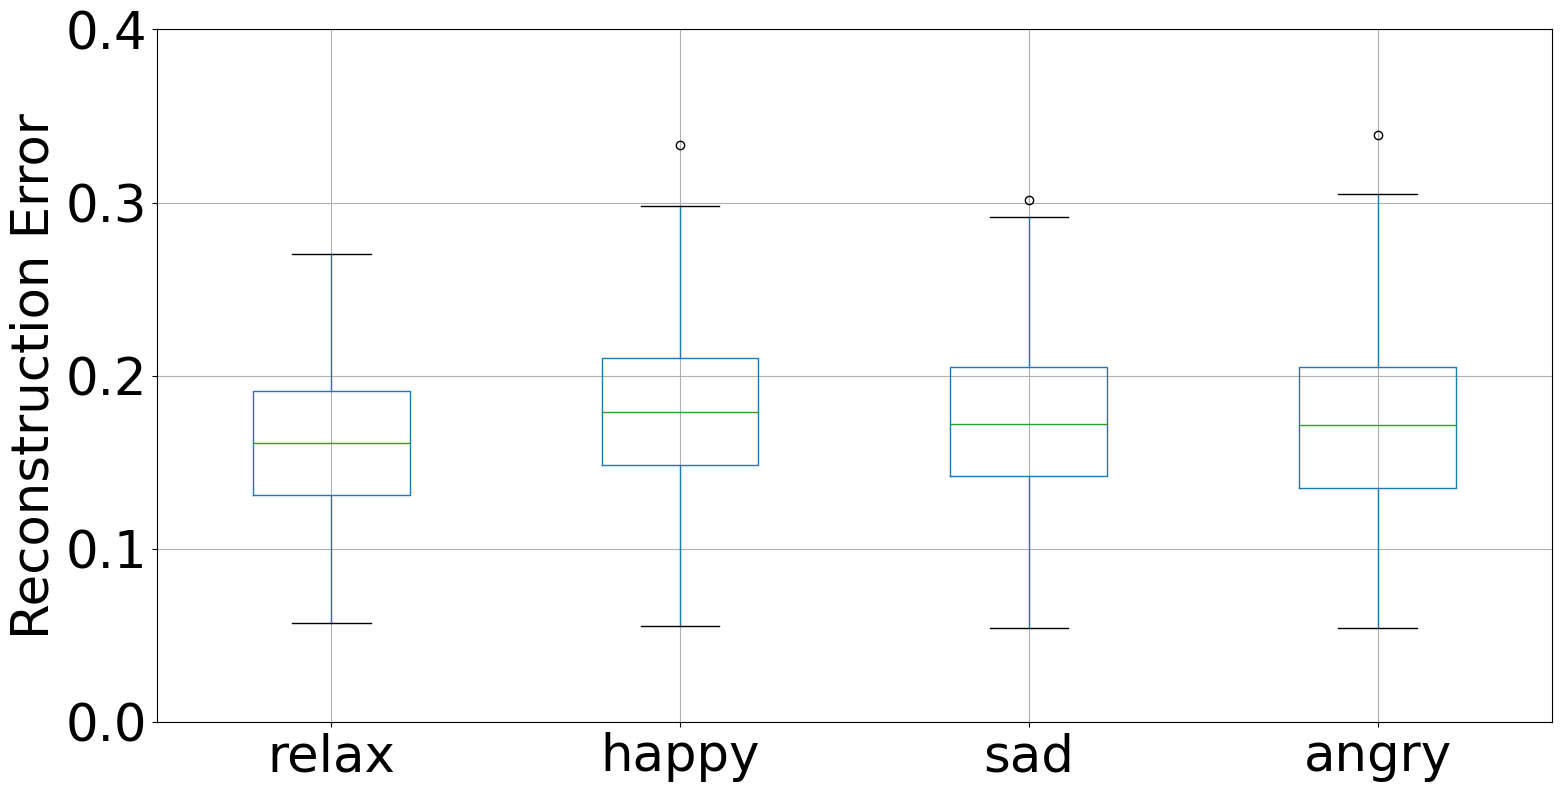

In [ ]:
Music = dataframe_M(dataset_Music_history)
plot_box(Music, columns, fig = 'Emotion')

In [ ]:
#Music